In [165]:
import csv
import numpy as np
import math
import pandas as pd
from collections import deque
import copy

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
from matplotlib import animation
import IPython

__requires__= 'networkx==2.5'
import networkx as nx
print("Networkx version: " + nx.__version__)

%matplotlib nbagg

Networkx version: 2.5


# Identifying Communities by Modularity Optimization

Communities in networks can be identified through the minimization of graph modularity.  In the following cells, an algorithm to find communities is implemented for a mock 2-dimensional system.  This is later applied to a 3D chemical system.


The mock 2D system is created as a "ring of rings".  Where pairs of smaller rings are adjusted to sit more adjacent to each other.  This data set is structured this as to create communities of communities in order to properly demonstrated the iterative process of finding "super" communities within a graph.

<IPython.core.display.Javascript object>


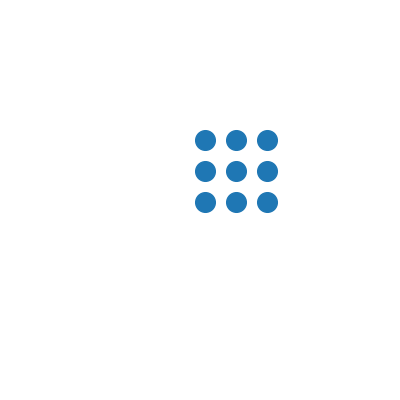

<ipython-input-166-7245a889ac15>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


In [166]:
x = [0,1,2,0,1,2,0,1,2]
y = [2,2,2,1,1,1,0,0,0]
# x=x/2
fig_size=4
marker_size=fig_size*50
fig = plt.figure(figsize=(fig_size,fig_size))
plt.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
ax = plt.axes()
ax.set_axis_off()
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)

plt.scatter(x,y, s=marker_size)

# Graph of the 2D System

This function takes the xy data from the 2D system and a user defined distance criteria to create weighted graph.  The graph node attributes are the cartesian coordinates, node color, and a community ID initially set to the node number.  

The graph edges are created for node pairs within the distance criteria and are weighted as the inverse of the euclidean distance.  

In [181]:
def create_primary_graph(x,y,distance_criteria=2**(1/2)): 

    graph=nx.Graph()
    
    for i in range(len(x)):
        graph.add_node(i,
                   x_coord = float(x[i]),
                   y_coord = float(y[i]),
                   z_coord = 0,
                   color = 'white',
                   community_ID = i,
                  )


    #add graph edges based on distances
    #weight edges based on inverse distance
#     for i in range(len(x)):
#         for j in range(len(x)):
#             if (i<j):
#                 xi=graph.nodes[i]['x_coord']
#                 xj=graph.nodes[j]['x_coord']
#                 yi=graph.nodes[i]['y_coord']
#                 yj=graph.nodes[j]['y_coord']
#                 distance=np.sqrt((xi-xj)**2+(yi-yj)**2)
                
#                 if ( distance <= distance_criteria):
#                     graph.add_edge(i,j,weight = 1/distance)
        graph.add_edge(0,3,weight=1)
#         graph.add_edge(0,4,weight=1)
        graph.add_edge(1,2,weight=1)
        graph.add_edge(1,5,weight=1/(2**(.5)))
#         graph.add_edge(1,5,weight=1)
        graph.add_edge(2,5,weight=1)
        graph.add_edge(3,4,weight=1)
        graph.add_edge(4,5,weight=1)
        graph.add_edge(4,7,weight=1)
        graph.add_edge(6,7,weight=1)
        graph.add_edge(7,8,weight=1)
    return graph
                            
G=create_primary_graph(x,y,distance_criteria=1)

# Plotting

This function colors the nodes in the graph to a user defined color map as a function of community ID.  The minimum and maximum ID's are used to normalize the spread of the cluster ID numbers across the maximum color gradient length.

A set of line segment are also added to visualize the edges in the graph.

Initially, each node has a unique community ID, and so the first graph shows node associations.

In [182]:
def plot_graph(graph: "networkx.classes.graph.Graph", color_map):
    
    text = []

    plt.figure(figsize=(fig_size,fig_size))
    ax = plt.axes()
    ax.set_axis_off()

    #Map graph node colors to color map
    min=len(graph.nodes())
    max=0
    for node in graph.nodes():
        if graph.nodes[node]['community_ID']<min:
            min=graph.nodes[node]['community_ID']
        if graph.nodes[node]['community_ID']>max:
            max=graph.nodes[node]['community_ID']
    gradientDistance=max-min
    for node in graph.nodes():
        graph.nodes[node]['color']=eval("cm." + color_map + "((graph.nodes[node]['community_ID']-min)/gradientDistance)")




    #plot graph nodes
    for i in range(len(graph.nodes())):
        ax.scatter(
            graph.nodes[i]['x_coord'],
            graph.nodes[i]['y_coord'],
            color= graph.nodes[i]['color'],
            edgecolors='black',
            s=marker_size,
            zorder=3
        )

        #annotate nodes with community ID number            
        text.append( ax.text(
            graph.nodes[i]['x_coord'],
            graph.nodes[i]['y_coord'],
            graph.nodes[i]['community_ID'],
            ha='center', va='center'
        ))

    #plot graph edges as line segments
    segments=deque()
    for i in range(len(graph.edges())):
        u=list(graph.edges)[i][0]
        v=list(graph.edges)[i][1]
        segment=[(
            graph.nodes[u]['x_coord'],
            graph.nodes[u]['y_coord']),(
            graph.nodes[v]['x_coord'],
            graph.nodes[v]['y_coord']
        )]
        segments.append(segment)

    lc = LineCollection(segments, colors='dimgray',linestyle='--')
    ax.add_collection(lc)

<IPython.core.display.Javascript object>


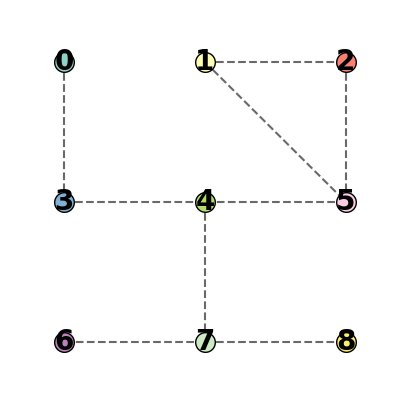

In [183]:
plot_graph(G,'Set3')

# Community Partition

The community partition value to be maximized is given by the product of the graph modularity and a delta function. The graph modularity $X$ is given by the following equation.

$X=\frac{1}{2m}\sum_{ij}{[A_{ij}-\frac{k_ik_j}{2m}]}$ where

$A_{ij}$ is the weight of the edge between $i$ and $j$

$k_i=\sum_jA_{ij}$ is the sum of weights of edges to $i$

$m=\frac{1}{2}\sum_{ij}A_{ij}$

The community partition function Q is then 

$Q=X\delta(c_i,c_j)$ where

$\delta$ is the delta function of $c_i,c_j$ where

$c_i$ is the community of $i$

The following function calculates the community partion for a given graph.

In [184]:
X=pd.DataFrame(nx.modularity_matrix(G,weight='weight'))
X

0         1         2         3         4         5         6  \
0 -0.057424  0.885151 -0.098030 -0.114849 -0.155454 -0.172273 -0.172273   
1  0.885151 -0.229697 -0.196059 -0.229697 -0.310908  0.655454 -0.344546   
2 -0.098030 -0.196059 -0.167347  0.803941  0.441730 -0.294089 -0.294089   
3 -0.114849 -0.229697  0.803941 -0.229697  0.689092 -0.344546 -0.344546   
4 -0.155454 -0.310908  0.441730  0.689092 -0.420830  0.533638 -0.466362   
5 -0.172273  0.655454 -0.294089 -0.344546  0.533638 -0.516819  0.483181   
6 -0.172273 -0.344546 -0.294089 -0.344546 -0.466362  0.483181 -0.516819   
7 -0.057424 -0.114849 -0.098030 -0.114849 -0.155454 -0.172273  0.827727   
8 -0.057424 -0.114849 -0.098030 -0.114849 -0.155454 -0.172273  0.827727   

          7         8  
0 -0.057424 -0.057424  
1 -0.114849 -0.114849  
2 -0.098030 -0.098030  
3 -0.114849 -0.114849  
4 -0.155454 -0.155454  
5 -0.172273 -0.172273  
6  0.827727  0.827727  
7 -0.057424 -0.057424  
8 -0.057424 -0.057424

In [190]:
#calculate  Q
def calcQ(graph: "networkx.classes.graph.Graph"):
    X=pd.DataFrame(nx.modularity_matrix(graph, weight='weight'))
#     print(X)
    Q=0
    for index_i, node_i in enumerate(graph.nodes()):
        for index_j, node_j in enumerate(graph.nodes()):
            if (graph.nodes[node_i]['community_ID']==graph.nodes[node_j]['community_ID']):
                delta_c=1
            if (graph.nodes[node_i]['community_ID']!=graph.nodes[node_j]['community_ID']):
                delta_c=0
            X[index_i][index_j]*=delta_c
            
            Q+=X[index_i][index_j]
    
    Q/=2*len(graph.edges())
    return Q

# Maximize Q

In first phase of the community partition maximization, nodes are moved to new communitites and the a new partition function is calculated.  If the new Q is greater than the previous value the move to the new community is accepted.  This is performed iteratively over all nodes until the value of Q no longer changes.

In this function, an initial plot of the graph is made, and upon successful movement of a node to a new community, the graph node color and community ID are updated to reflect the change.  At the end of this process the first level of communities are defined, but the larger communities of communities have still not been successfully grouped together.

<IPython.core.display.Javascript object>


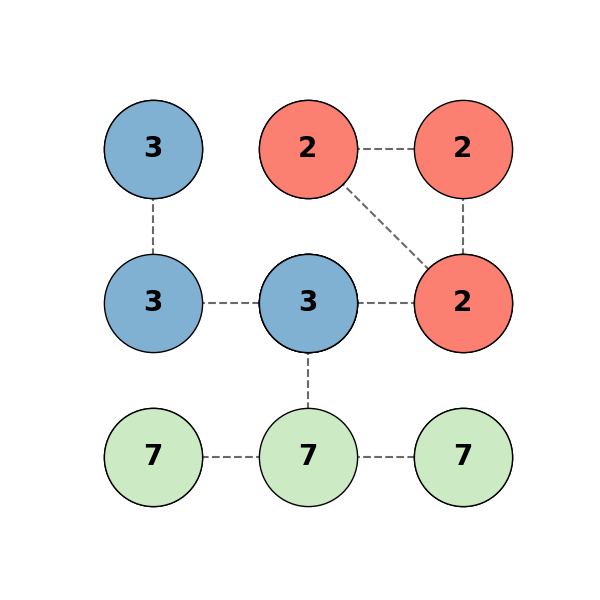

-0.12519352062792002
Press Enter to continue...
-0.0268433775287309
Press Enter to continue...
0.062483398554723436
Press Enter to continue...
0.1161701536121853
Press Enter to continue...
0.12177655510646633
Press Enter to continue...
0.18813036621958976
Press Enter to continue...
0.28010002531281786
Press Enter to continue...
0.3656892004000849
Press Enter to continue...
0.41937595545754675


In [ ]:
def phase1(graph):
    
#     graph_copy = graph
    graph_copy = copy.deepcopy(graph)
    
    fig_size=6
    marker_size=5000
    fig = plt.figure(figsize=(fig_size,fig_size))
    ax = plt.axes()
    ax.set_axis_off()
    lim=1.5
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(-0.5,2.5)
    text = []
    plt.rc('font', size=20, weight='bold')          # controls default text sizes
    for i in range(len(graph_copy.nodes())):
        ax.scatter(
            graph_copy.nodes[i]['x_coord'],
            graph_copy.nodes[i]['y_coord'],
            color= graph_copy.nodes[i]['color'],
            edgecolors='black',
            s=marker_size,
            zorder = 3
        )
        text.append( ax.text(
            graph_copy.nodes[i]['x_coord'],
            graph_copy.nodes[i]['y_coord'],
            graph_copy.nodes[i]['community_ID'],
            ha='center', va='center'
        ))

    segments=deque()
    for i in range(len(graph_copy.edges())):
        u=list(graph_copy.edges)[i][0]
        v=list(graph_copy.edges)[i][1]
        segment=[(
            graph_copy.nodes[u]['x_coord'],
            graph_copy.nodes[u]['y_coord']),(
            graph_copy.nodes[v]['x_coord'],
            graph_copy.nodes[v]['y_coord']
        )]
        segments.append(segment)

    lc = LineCollection(segments, colors='dimgray',linestyle='--')
    ax.add_collection(lc)


    

    
    convergedQ='NA'
    Q=calcQ(graph_copy)
    
    fig.canvas.draw()
    print(Q)
    input("Press Enter to continue...")

    while convergedQ != Q:
        convergedQ=Q
        for i in range(len(graph_copy.nodes())):
            for j in nx.neighbors(graph_copy,i):
                origCommunityID=graph_copy.nodes[i]['community_ID']
                C=graph_copy.nodes[j]['community_ID']  #new Community
                if graph_copy.nodes[i]['community_ID']!=C:
                    graph_copy.nodes[i]['community_ID']=C
                    graph_copy.nodes[i]['community_ID']=graph_copy.nodes[j]['community_ID']
                    newQ=calcQ(graph_copy)
                    if (newQ<=Q):
                        graph_copy.nodes[i]['community_ID']=origCommunityID
                    if (newQ>Q):

                        Q=newQ
                        print(Q)
                        #recolor and relabel node
                        graph_copy.nodes[i]['color']=graph_copy.nodes[j]['color']
                        ax.scatter(
                            graph_copy.nodes[i]['x_coord'],
                            graph_copy.nodes[i]['y_coord'],
                            color= graph_copy.nodes[i]['color'],
                            edgecolors='black',
                            s=marker_size,
                            zorder = 3
                        )
                        text[i].set_text(graph_copy.nodes[i]['community_ID'])
                        fig.canvas.draw()
                        input("Press Enter to continue...")
    return(graph_copy)
                        
H= phase1(G)
# H=phase1(H)

In [116]:
def create_super_graph(primary_graph): 

    super_graph = nx.Graph()

    #Initialize new graph with node ID's as the clusters from the original graph
    for node in primary_graph.nodes():
        super_graph.add_node(H.nodes[node]['community_ID'],
            community_ID = primary_graph.nodes[node]['community_ID'],
            community_members = [],
            color = primary_graph.nodes[node]['color']
            )

    #Populate each cluster with list of original node members
    for node in primary_graph.nodes():
        super_graph.nodes[primary_graph.nodes[node]['community_ID']]['community_members'].append(node)


    #Find edges between clusters and weight by sum of the two clusters
    for node in primary_graph.nodes():
        for neighbor in (nx.neighbors(primary_graph,node)):
            node_community = primary_graph.nodes[node]['community_ID']
            neigbor_community = primary_graph.nodes[neighbor]['community_ID']
            if node_community != neigbor_community:
                super_graph.add_edge(node_community,neigbor_community, weight = 0)
                super_graph.edges[node_community, neigbor_community]['weight'] += (
                 primary_graph.edges[node,neighbor]['weight'])
                
    return super_graph

H1= copy.deepcopy(H)
super_graph = create_super_graph(H1)

<IPython.core.display.Javascript object>


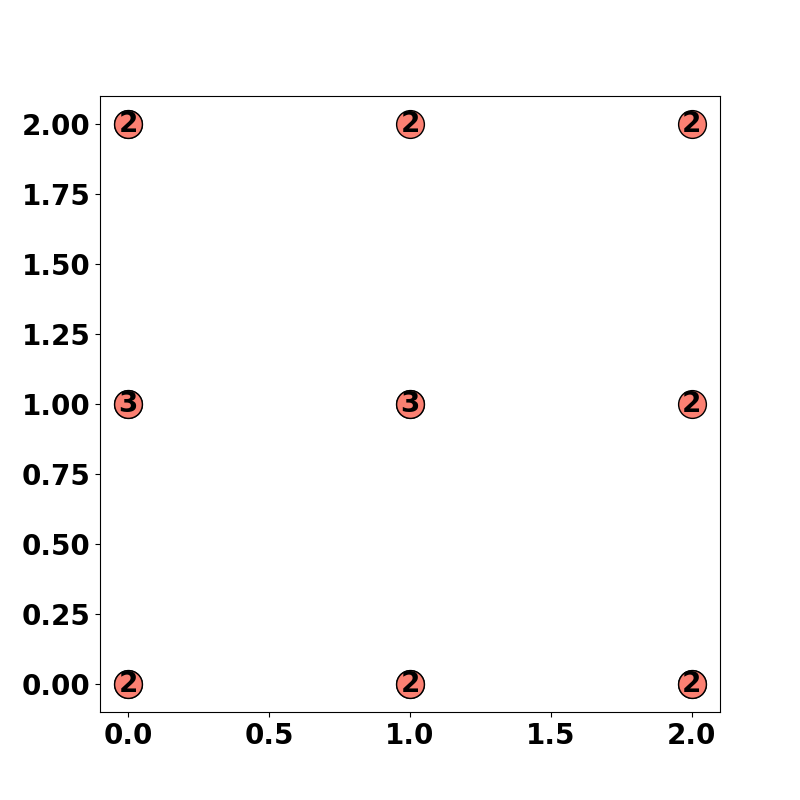

-0.375
-0.375
-0.125
-0.125
-0.125
0.0
{0: 2, 3: 2, 1: 2, 2: 2, 5: 2, 4: 2, 7: 2, 6: 2, 8: 2}


In [147]:
def phase2(primary_graph, super_graph):
    
    primary_graph_copy = copy.deepcopy(primary_graph) #copy of lowest level graph
    super_graph_copy = copy.deepcopy(super_graph) #copy of super community graph

    #plot initial figure
    fig_size=8
    marker_size=fig_size*50
    fig = plt.figure(figsize=(fig_size,fig_size))
    ax = plt.axes()
    text = []
    for node in primary_graph_copy.nodes():
        ax.scatter(
            primary_graph_copy.nodes[node]['x_coord'],
            primary_graph_copy.nodes[node]['y_coord'],
            color= primary_graph_copy.nodes[node]['color'],
            edgecolors='black',
            s=marker_size,
        )
        text.append( ax.text(
            primary_graph_copy.nodes[node]['x_coord'],
            primary_graph_copy.nodes[node]['y_coord'],
            primary_graph_copy.nodes[node]['community_ID'],
            ha='center', va='center'
        ))


    convergedQ='NA'
    Q=calcQ(super_graph_copy)
    print(Q)
    while convergedQ != Q:
        convergedQ=Q
        for node in super_graph.nodes():
#             print('node', node)
            for neighbor in nx.neighbors(super_graph,node):
#                 print('neighbor', neighbor)
                origCommunityID=super_graph_copy.nodes[node]['community_ID']
                C=super_graph_copy.nodes[neighbor]['community_ID']  #new Community
                if super_graph_copy.nodes[node]['community_ID']!=C:
                    super_graph_copy.nodes[node]['community_ID']=C
#                     super_graph_copy.nodes[node]['community_ID']=super_graph_copy.nodes[neighbor]['community_ID']
                    newQ=calcQ(super_graph_copy)
                    print(Q)
                    if (newQ<=Q):
                        super_graph_copy.nodes[node]['community_ID']=origCommunityID
                    if (newQ>Q):
                        Q=newQ
                        print(Q)
                        super_graph_copy.nodes[node]['color']=super_graph_copy.nodes[neighbor]['color']

                        #relabel and recolor nodes of lowest level graph to match super graph
                        #properties

                        #update plot of lowest level graph
                        for community_member in super_graph_copy.nodes[node]['community_members']:
                            primary_graph_copy.nodes[community_member]['community_ID']=super_graph_copy.nodes[neighbor]['community_ID']
                            primary_graph_copy.nodes[community_member]['color']=super_graph_copy.nodes[node]['color']
                            ax.scatter(
                                primary_graph_copy.nodes[community_member]['x_coord'],
                                primary_graph_copy.nodes[community_member]['y_coord'],
                                color= primary_graph_copy.nodes[community_member]['color'],
                                edgecolors='black',
                                s=marker_size,
                            )
                            text[community_member].set_text(primary_graph_copy.nodes[community_member]['community_ID'])

                        #update figure
#                         fig.canvas.draw()
    print(nx.get_node_attributes(primary_graph_copy, "community_ID"))
    return primary_graph_copy
final_graph = phase2(H1,super_graph)



In [132]:
# final_graph = phase2(H1,super_graph)

print(nx.get_node_attributes(final_graph, "community_ID"))

# plot_graph(final_graph,'Set3')

{0: 2, 3: 2, 1: 2, 2: 2, 5: 2, 4: 2, 7: 2, 6: 2, 8: 2}


<IPython.core.display.Javascript object>


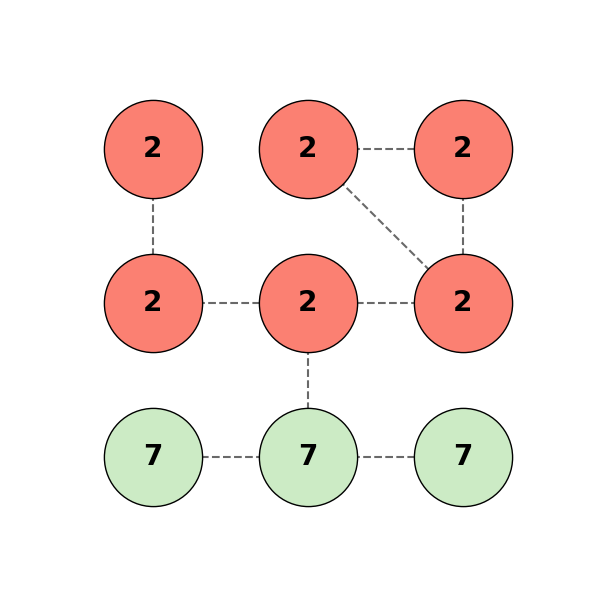

In [142]:
fig_size=6
marker_size=5000
fig = plt.figure(figsize=(fig_size,fig_size))
ax = plt.axes()
ax.set_axis_off()
lim=1.5
ax.set_xlim(-0.5,2.5)
ax.set_ylim(-0.5,2.5)
text = []
plt.rc('font', size=20, weight='bold')          # controls default text sizes
for i in range(len(final_graph.nodes())):
    ax.scatter(
        final_graph.nodes[i]['x_coord'],
        final_graph.nodes[i]['y_coord'],
        color= final_graph.nodes[i]['color'],
        edgecolors='black',
        s=marker_size,
        zorder = 3
    )
    text.append( ax.text(
        final_graph.nodes[i]['x_coord'],
        final_graph.nodes[i]['y_coord'],
        final_graph.nodes[i]['community_ID'],
        ha='center', va='center'
    ))

segments=deque()
for i in range(len(final_graph.edges())):
    u=list(final_graph.edges)[i][0]
    v=list(final_graph.edges)[i][1]
    segment=[(
        final_graph.nodes[u]['x_coord'],
        final_graph.nodes[u]['y_coord']),(
        final_graph.nodes[v]['x_coord'],
        final_graph.nodes[v]['y_coord']
    )]
    segments.append(segment)

lc = LineCollection(segments, colors='dimgray',linestyle='--')
ax.add_collection(lc)
fig.canvas.draw()


In [134]:
calcQ(final_graph)


7.093091546216277e-17

In [141]:
final_graph.nodes[6]['community_ID']=7
final_graph.nodes[7]['community_ID']=7
final_graph.nodes[8]['community_ID']=7
final_graph.nodes[6]['color']=(0.8, 0.9215686274509803, 0.7725490196078432, 1.0)
final_graph.nodes[7]['color']=(0.8, 0.9215686274509803, 0.7725490196078432, 1.0)
final_graph.nodes[8]['color']=(0.8, 0.9215686274509803, 0.7725490196078432, 1.0)


In [138]:
print(G.nodes[7]['color'])

(0.8, 0.9215686274509803, 0.7725490196078432, 1.0)
